In [3]:

















# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/santander-product-recommendation/test_ver2.csv.zip
/kaggle/input/santander-product-recommendation/sample_submission.csv.zip
/kaggle/input/santander-product-recommendation/train_ver2.csv.zip


In [4]:
import csv
import datetime as dt

# Data Viz 
import seaborn as sns
import matplotlib.pyplot as plt

# Data Manipulation
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# Similarity calculation
from sklearn.metrics.pairwise import cosine_similarity

# Import ML libraries
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

# settings
pd.options.display.max_rows = 100
pd.options.display.max_columns = None

In [5]:
data= pd.read_csv(filepath_or_buffer='/kaggle/input/santander-product-recommendation/train_ver2.csv.zip')

/tmp/ipykernel_33/1496469937.py:1: DtypeWarning: Columns (5,8,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  data= pd.read_csv(filepath_or_buffer='/kaggle/input/santander-product-recommendation/train_ver2.csv.zip')


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13647309 entries, 0 to 13647308
Data columns (total 48 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   fecha_dato             object 
 1   ncodpers               int64  
 2   ind_empleado           object 
 3   pais_residencia        object 
 4   sexo                   object 
 5   age                    object 
 6   fecha_alta             object 
 7   ind_nuevo              float64
 8   antiguedad             object 
 9   indrel                 float64
 10  ult_fec_cli_1t         object 
 11  indrel_1mes            object 
 12  tiprel_1mes            object 
 13  indresi                object 
 14  indext                 object 
 15  conyuemp               object 
 16  canal_entrada          object 
 17  indfall                object 
 18  tipodom                float64
 19  cod_prov               float64
 20  nomprov                object 
 21  ind_actividad_cliente  float64
 22  renta           

# ult_fec_cli_1t (Primary Customer)
knowing the Primary customer for a bank is important, and it is important to factor in deciding customer will buy the product, hence I replace all non-null values a 1 (that the intended person is primary) and null value as 0

In [7]:
data.ult_fec_cli_1t.isnull().sum()

13622516

In [8]:
data['ult_fec_cli_1t'] = data['ult_fec_cli_1t'].replace(np.nan, 0)
data['ult_fec_cli_1t'] = data['ult_fec_cli_1t'].where(data['ult_fec_cli_1t'] == 0, 1)
data['ult_fec_cli_1t'].value_counts()

ult_fec_cli_1t
0    13622516
1       24793
Name: count, dtype: int64

# Conyuemp (Spouse Index)
Probably this is the inference that Bank employees are educated enough to tell their spouses which product to buy.

However, if we see below, only 178 data were collected from total 999999 data (0.0178%). Hence dropping this column from our feature since it is not nice to impute data which are missing in the majority.

In [9]:
data.drop(['conyuemp'], axis = 1, inplace = True)

# renta (Gross Household Income)
Since “Gross income of household” is an important feature on deciding a customer’s economical status which in turn help to decide whether the customer will buy the product or not, we cannot discard/drop this column altogether. Also dropping the rows, which do not has any value in this fields is not justifiable since in the real world we cannot force a customer to reveal their income. so will be imputing MOD value on the NAN cells.

In [10]:
data['renta'] = data['renta'].fillna(data['renta'].mode()[0])
# data.renta.isnull().sum()

# cod_prov (Customer Provision)
Customer Provision is an important value since according to Region, people's financial exposure is judged. in Big City, since people need to pay high taxes and they are more educated as compared to people from suburbs. Hence it is better to drop all the records whose Provisional code is not mentioned.

In [11]:
data.dropna(subset=['cod_prov'], how='all', inplace=True)
data.cod_prov.isnull().sum()

0

# segemento (Segementation)
Since it is only 40 records(0.0088%), we delete them after dropping the dataframe size remaining : (982078, 47)

In [12]:
data.dropna(subset=['segmento'], how='all', inplace=True)
data.segmento.isnull().sum()

0

# canal_entrada (channel_used)
Since it is only 19 records(0.0019%), we delete them after dropping the dataframe size remaining : (982059, 47)

In [13]:
data.dropna(subset=['canal_entrada'], how='all', inplace=True)
data.isnull().sum()

fecha_dato                 0
ncodpers                   0
ind_empleado               0
pais_residencia            0
sexo                      69
age                        0
fecha_alta                 0
ind_nuevo                  0
antiguedad                 0
indrel                     0
ult_fec_cli_1t             0
indrel_1mes               67
tiprel_1mes               67
indresi                    0
indext                     0
canal_entrada              0
indfall                    0
tipodom                    0
cod_prov                   0
nomprov                    0
ind_actividad_cliente      0
renta                      0
segmento                   0
ind_ahor_fin_ult1          0
ind_aval_fin_ult1          0
ind_cco_fin_ult1           0
ind_cder_fin_ult1          0
ind_cno_fin_ult1           0
ind_ctju_fin_ult1          0
ind_ctma_fin_ult1          0
ind_ctop_fin_ult1          0
ind_ctpp_fin_ult1          0
ind_deco_fin_ult1          0
ind_deme_fin_ult1          0
ind_dela_fin_u

# Sexo (Sex)
Since in the dataset there were only 4 records(0.0004%), hence we deleted those records.

In [14]:
data.dropna(subset=['sexo'], how='all', inplace=True)

In [15]:
data.sexo.value_counts()

sexo
V    7299153
H    6092253
Name: count, dtype: int64

In [16]:
#plot for age and sex

# Age (to bins)

In [17]:
data['age']=data['age'].astype('int')
bins = [0, 18, 25, 35, 45,60,80,100,120]  # Use float('inf') for ages greater than 80
labels = [0,1,2, 3, 4,5,6,7]  # These correspond to your specified age groups

# Use pd.cut to create age groups and assign them to a new 'age_group' column
data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels, right=False)

# Optional: Drop the old 'age' column if it's no longer needed
data.drop(columns=['age'], inplace=True)

data.age_group.value_counts()

age_group
1    3309203
4    3152716
3    2606396
2    2381948
5    1430578
6     377189
0     117981
7      15373
Name: count, dtype: int64

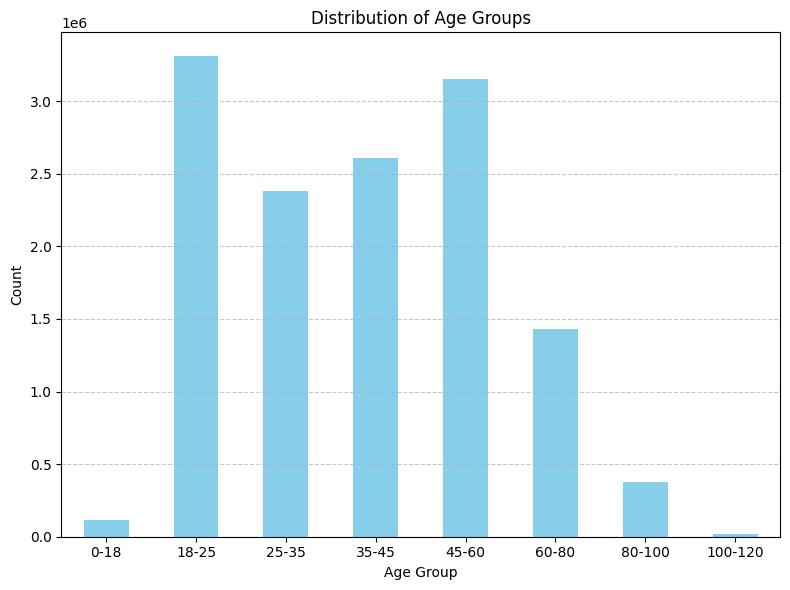

In [18]:
import matplotlib.pyplot as plt

# Define the age group labels
age_group_labels = ['0-18', '18-25', '25-35', '35-45', '45-60','60-80','80-100','100-120']

# Plotting the bar plot for age groups
plt.figure(figsize=(8, 6))
data['age_group'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(ticks=range(len(age_group_labels)), labels=age_group_labels, rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# ind_empleado (Employee index)
Employee index: A active, B ex employed, F filial, N not employee, P/S passive.import matplotlib.pyplot as plt

In [19]:
data['ind_empleado'].value_counts()
# data['ind_empleado'].isnull().sum()

ind_empleado
N    13382865
B        3537
F        2512
A        2475
S          17
Name: count, dtype: int64

 ’N’ has a major chunk of data

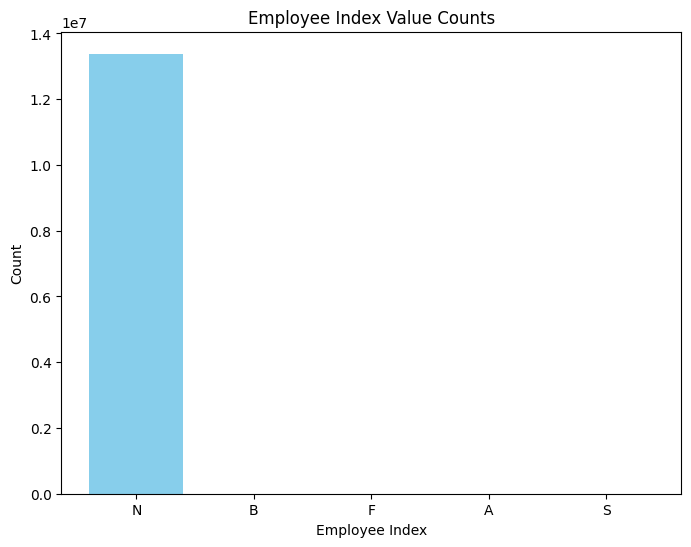

In [20]:
import matplotlib.pyplot as plt

# Data
employee_counts = {'N': 13382865, 'B': 3537, 'F': 2512, 'A': 2475, 'S': 17}

# Plot
plt.figure(figsize=(8, 6))
plt.bar(employee_counts.keys(), employee_counts.values(), color='skyblue')
plt.xlabel('Employee Index')
plt.ylabel('Count')
plt.title('Employee Index Value Counts')
plt.show()


# pais_residencia (Customer's country residence)


In [21]:
data['pais_residencia'].value_counts()
# data['pais_residencia'].isnull().sum()

pais_residencia
ES    13391323
IT          33
DE          17
BO          17
PY          16
Name: count, dtype: int64

‘ES’ for Spain, has a major share of data
As seen above ‘ind_empleado’ and ‘pais_residencia’ data is highly imbalanced

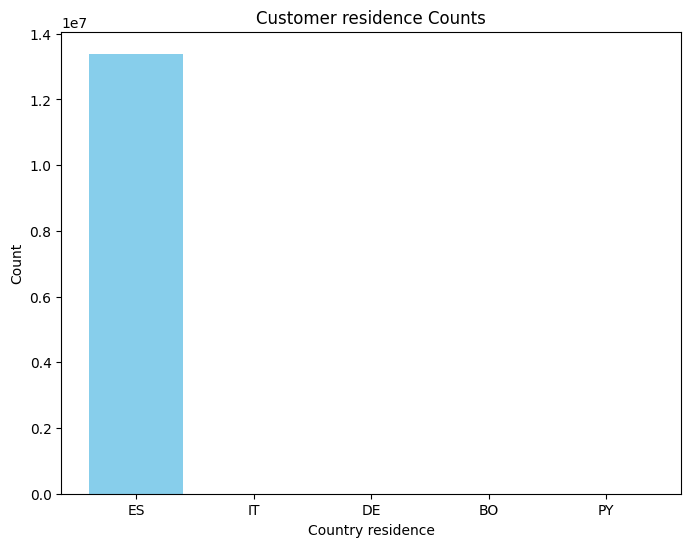

In [22]:
import matplotlib.pyplot as plt

# Data
residence_counts = {'ES':13391323, 'IT': 33, 'DE': 17, 'BO': 17, 'PY': 16}

# Plot
plt.figure(figsize=(8, 6))
plt.bar(residence_counts.keys(), residence_counts.values(), color='skyblue')
plt.xlabel('Country residence')
plt.ylabel('Count')
plt.title('Customer residence Counts')
plt.show()


In [23]:
#remove residence_index and employee_index later

# fetch_alta
The date in which the customer became as the first holder of a contract in the bank

In [24]:
# Convert 'fecha_alta' to datetime format
data['fecha_alta'] = pd.to_datetime(data['fecha_alta'])

# Derive 'fecha_alta_year', 'fecha_alta_month', and 'fecha_alta_day' columns
data['fecha_alta_year'] = data['fecha_alta'].dt.year
data['fecha_alta_month'] = data['fecha_alta'].dt.month
data['fecha_alta_day'] = data['fecha_alta'].dt.day

# Drop the original 'fecha_alta' column
# data.drop(columns=['fecha_alta'], inplace=True)


In [25]:
data.fecha_alta_year

0           2015
1           2012
2           2012
3           2012
4           2012
            ... 
13647303    2013
13647304    2013
13647305    2013
13647306    2013
13647307    2013
Name: fecha_alta_year, Length: 13391406, dtype: int32

# Plot for fecha_alta_year

1. The year 2014 has the max number of customer enrollment 
2. The year 2016 has the least enrollment
3. Age bin graph shows, the max enrollment which happens in the year 2014 is maximum from the age group (18–25].


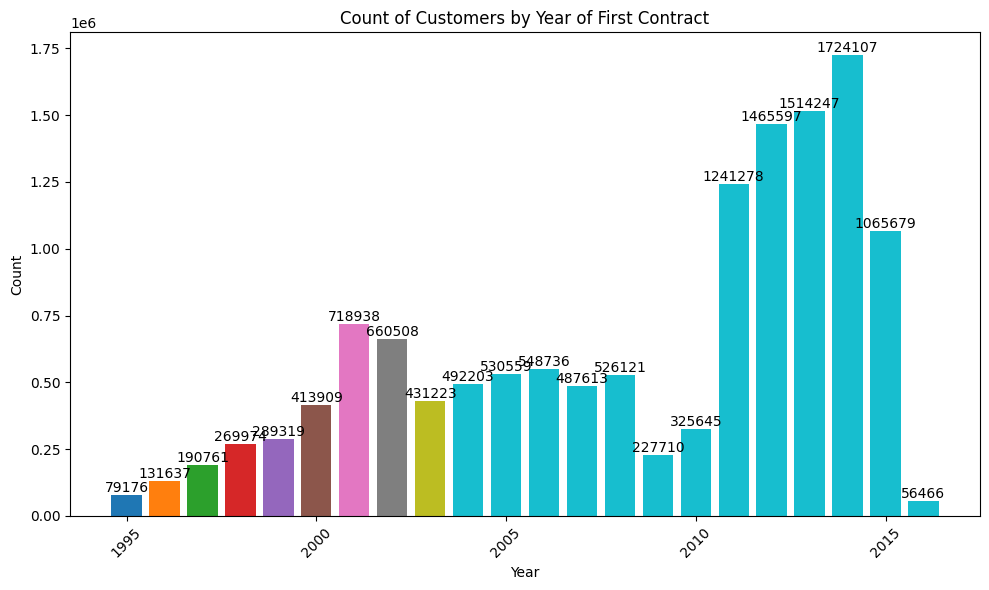

In [26]:
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame containing the 'fecha_alta_year' column

# Get unique years and their counts
year_counts = data['fecha_alta_year'].value_counts().sort_index()

# Define colors for each bar
colors = plt.cm.tab10(range(len(year_counts)))

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(year_counts.index, year_counts.values, color=colors)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Count of Customers by Year of First Contract')

# Add labels for each bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(int(bar.get_height())), ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipykernel_33/1496157632.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(['fecha_alta_year', 'age_group']).size().unstack(fill_value=0).reset_index()


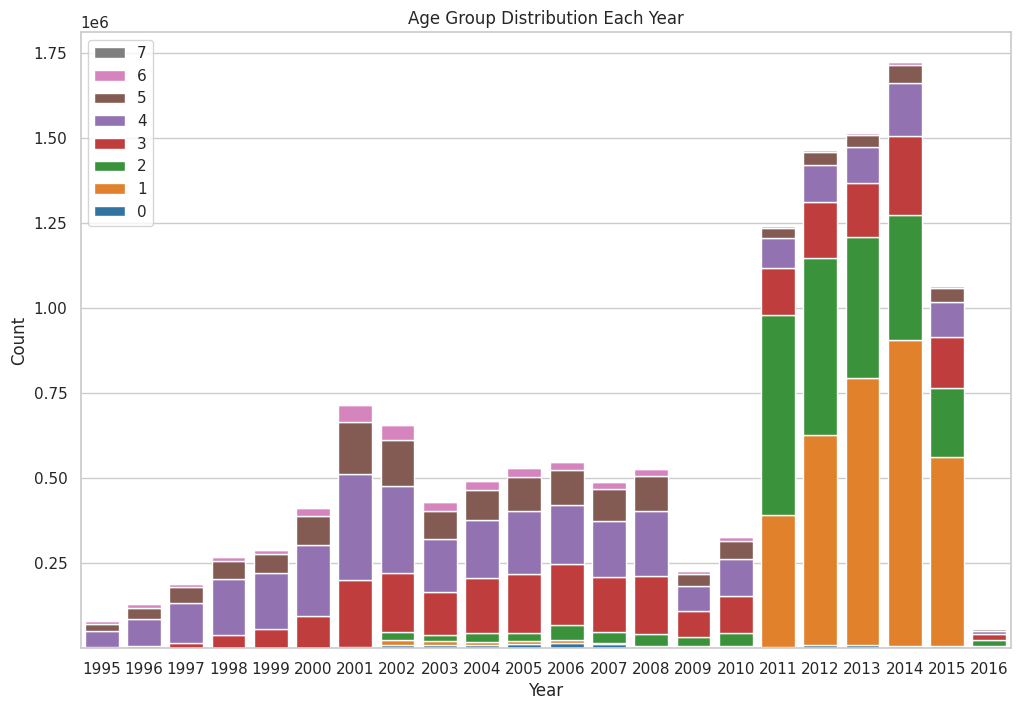

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group data by year and age group, and calculate counts
grouped_data = data.groupby(['fecha_alta_year', 'age_group']).size().unstack(fill_value=0).reset_index()

# Set seaborn style
sns.set(style="whitegrid")

# Plot stacked bar plot for age groups for each year
plt.figure(figsize=(12, 8))

# Initialize bottom values for stacking
bottom_values = None

# Iterate over each age group and plot the bars
for i, age_group in enumerate(grouped_data.columns[1:]):
    if bottom_values is None:
        ax = sns.barplot(x='fecha_alta_year', y=age_group, data=grouped_data, color=sns.color_palette("tab10")[i], label=age_group)
        bottom_values = grouped_data[age_group]
    else:
        ax = sns.barplot(x='fecha_alta_year', y=age_group, data=grouped_data, color=sns.color_palette("tab10")[i], bottom=bottom_values, label=age_group)
        bottom_values += grouped_data[age_group]

# Set plot title and labels
ax.set_title('Age Group Distribution Each Year')
ax.set_xlabel('Year')
ax.set_ylabel('Count')

# Add legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='upper left')

plt.show()


#  fecha_alta_month
The month in which the customer became as the first holder of a contract in the bank

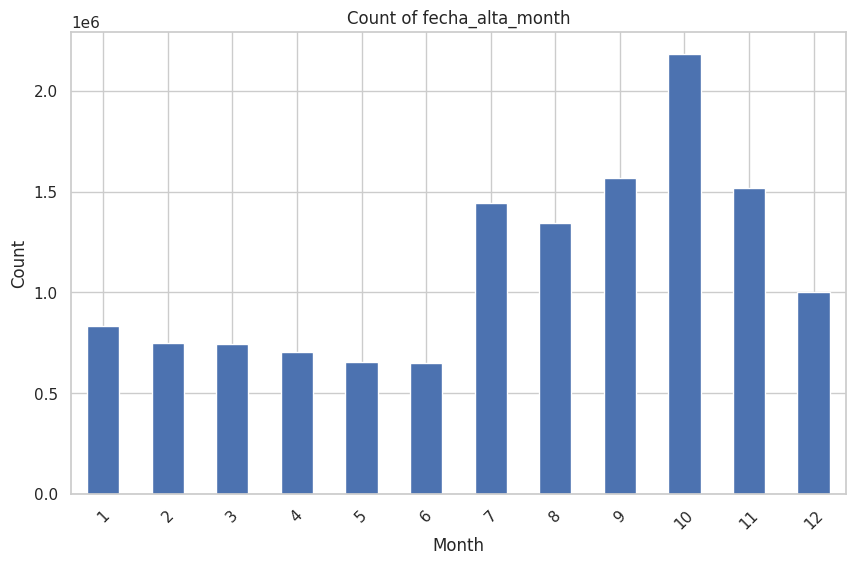

In [28]:
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame containing the column 'fecha_alta_month'

# Count the occurrences of each month
month_counts = data['fecha_alta_month'].value_counts()

# Sort the counts by month
month_counts = month_counts.sort_index()

# Plot the bar plot
plt.figure(figsize=(10, 6))
month_counts.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Count of fecha_alta_month')
plt.xticks(rotation=45)
plt.show()


1. Max enrollment happened in the month of October
2. (18,25], this is probably because this age group usually starts college and they opened a Bank account, or because their first job started hence they need to open a bank account.

/tmp/ipykernel_33/2526433450.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(['fecha_alta_month', 'age_group']).size().unstack(fill_value=0).reset_index()


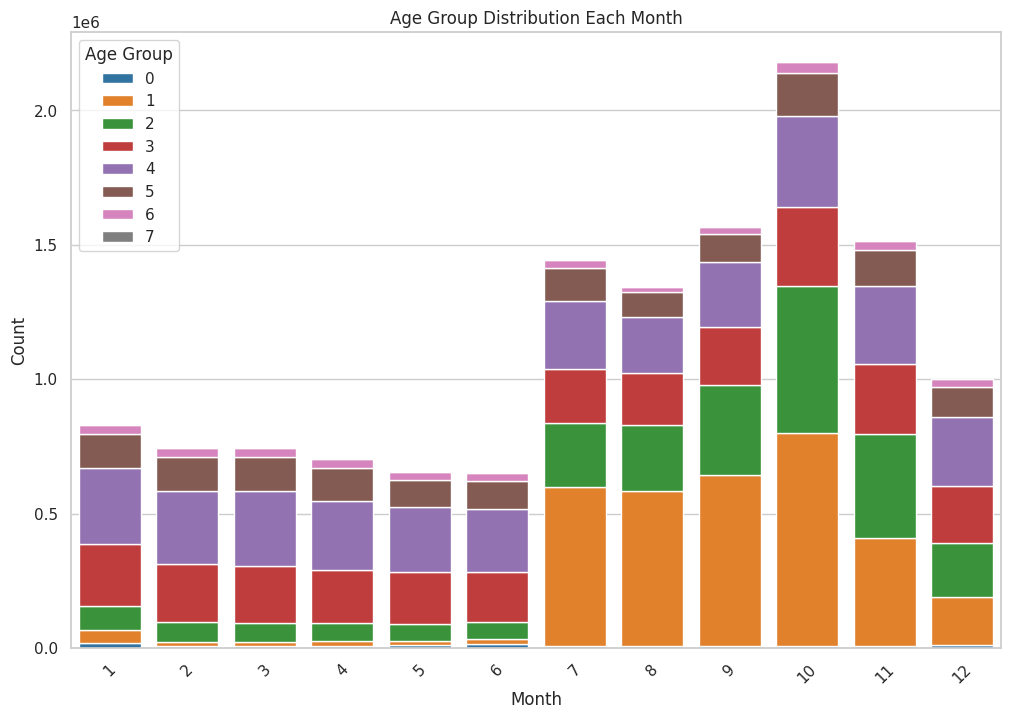

In [29]:
grouped_data = data.groupby(['fecha_alta_month', 'age_group']).size().unstack(fill_value=0).reset_index()


# Set seaborn style
sns.set(style="whitegrid")

# Plot stacked bar plot for age groups for each month
plt.figure(figsize=(12, 8))

# Initialize bottom values for stacking
bottom_values = None

# Iterate over each age group and plot the bars
for i, age_group in enumerate(grouped_data.columns[1:]):
    if bottom_values is None:
        ax = sns.barplot(x='fecha_alta_month', y=age_group, data=grouped_data, label=age_group,color=sns.color_palette("tab10")[i])
        bottom_values = grouped_data[age_group]
    else:
        ax = sns.barplot(x='fecha_alta_month', y=age_group, data=grouped_data, label=age_group, bottom=bottom_values,color=sns.color_palette("tab10")[i])
        bottom_values += grouped_data[age_group]

# Set plot title and labels
ax.set_title('Age Group Distribution Each Month')
ax.set_xlabel('Month')
ax.set_ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
plt.legend(title='Age Group', loc='upper left')

plt.show()

# tiprel_1mes
Customer relation type at the beginning of the month, A (active), I (inactive), P (former customer)

In [30]:
# data['tiprel_1mes'].isnull().sum()
data.dropna(subset=['tiprel_1mes'], how='all', inplace=True)

From age-bin analysis, Max Active customer is in age group (45,60] and maximum Inactive are in age group (18,25]

/tmp/ipykernel_33/1036305655.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(['tiprel_1mes', 'age_group']).size().unstack(fill_value=0).reset_index()


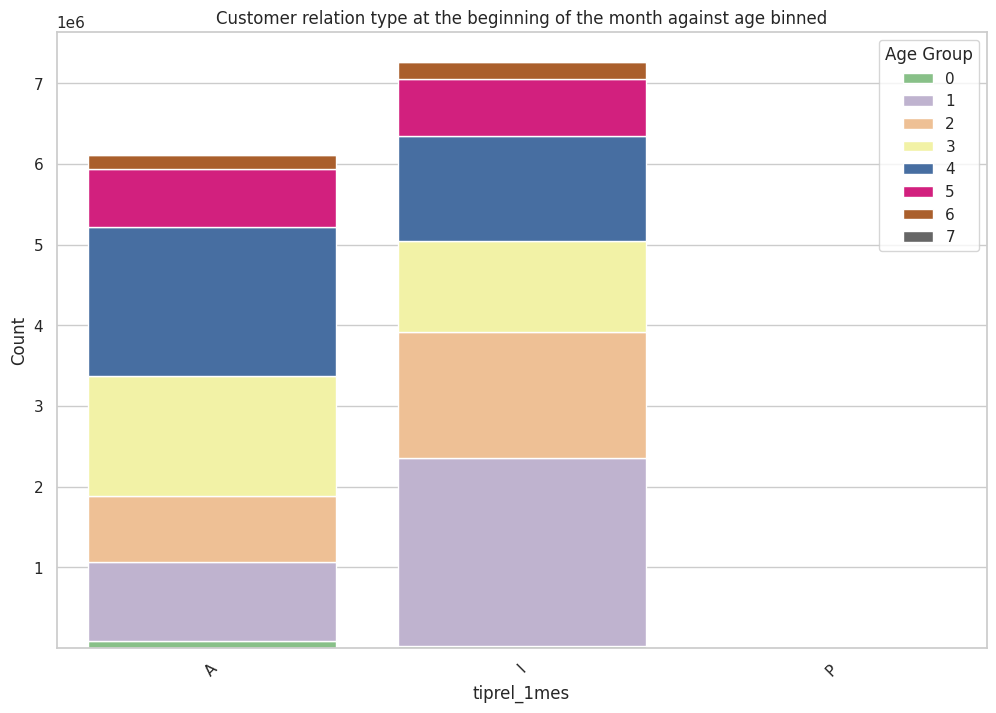

In [31]:
grouped_data = data.groupby(['tiprel_1mes', 'age_group']).size().unstack(fill_value=0).reset_index()


# Set seaborn style
sns.set(style="whitegrid")

# Plot stacked bar plot for age groups for each month
plt.figure(figsize=(12, 8))

# Initialize bottom values for stacking
bottom_values = None

# Iterate over each age group and plot the bars
for i, age_group in enumerate(grouped_data.columns[1:]):
    if bottom_values is None:
        ax = sns.barplot(x='tiprel_1mes', y=age_group, data=grouped_data, label=age_group,color=sns.color_palette("Accent")[i])
        bottom_values = grouped_data[age_group]
    else:
        ax = sns.barplot(x='tiprel_1mes', y=age_group, data=grouped_data, label=age_group, bottom=bottom_values,color=sns.color_palette("Accent")[i])
        bottom_values += grouped_data[age_group]

# Set plot title and labels
ax.set_title('Customer relation type at the beginning of the month against age binned')
ax.set_xlabel('tiprel_1mes')
ax.set_ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
plt.legend(title='Age Group', loc='upper right')

plt.show()

# Cod_prov and nomprov

In [32]:
data['cod_prov'].value_counts()

cod_prov
28.0    4364601
8.0     1259513
46.0     671513
41.0     599019
15.0     424048
30.0     390511
29.0     363816
50.0     338437
3.0      308324
11.0     291455
36.0     275976
33.0     262310
47.0     235744
35.0     232036
6.0      190863
48.0     184472
45.0     180483
18.0     176572
37.0     162166
39.0     153454
14.0     142881
10.0     128562
7.0      122498
21.0     121241
13.0     117900
2.0      112553
12.0     102868
43.0      97693
9.0       95932
17.0      89288
31.0      87578
26.0      84247
27.0      83932
32.0      82985
24.0      81967
25.0      77876
20.0      70883
38.0      69974
19.0      63699
23.0      63486
4.0       59410
16.0      56635
49.0      50315
34.0      48724
40.0      41861
22.0      39504
5.0       38322
1.0       37260
44.0      22209
42.0      17258
52.0       9343
51.0       7142
Name: count, dtype: int64

# ind_actividad_cliente
Activity index (1 — active customer; 0 — inactive customer).

The Age bin depicts Maximum Active Customers from the 35 to 80 years age group. Maximum Inactive customer is in (18,25] ager group. Since the feature is already in the numeral, hence no need to do the 

/tmp/ipykernel_33/625073437.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(['ind_actividad_cliente', 'age_group']).size().unstack(fill_value=0).reset_index()


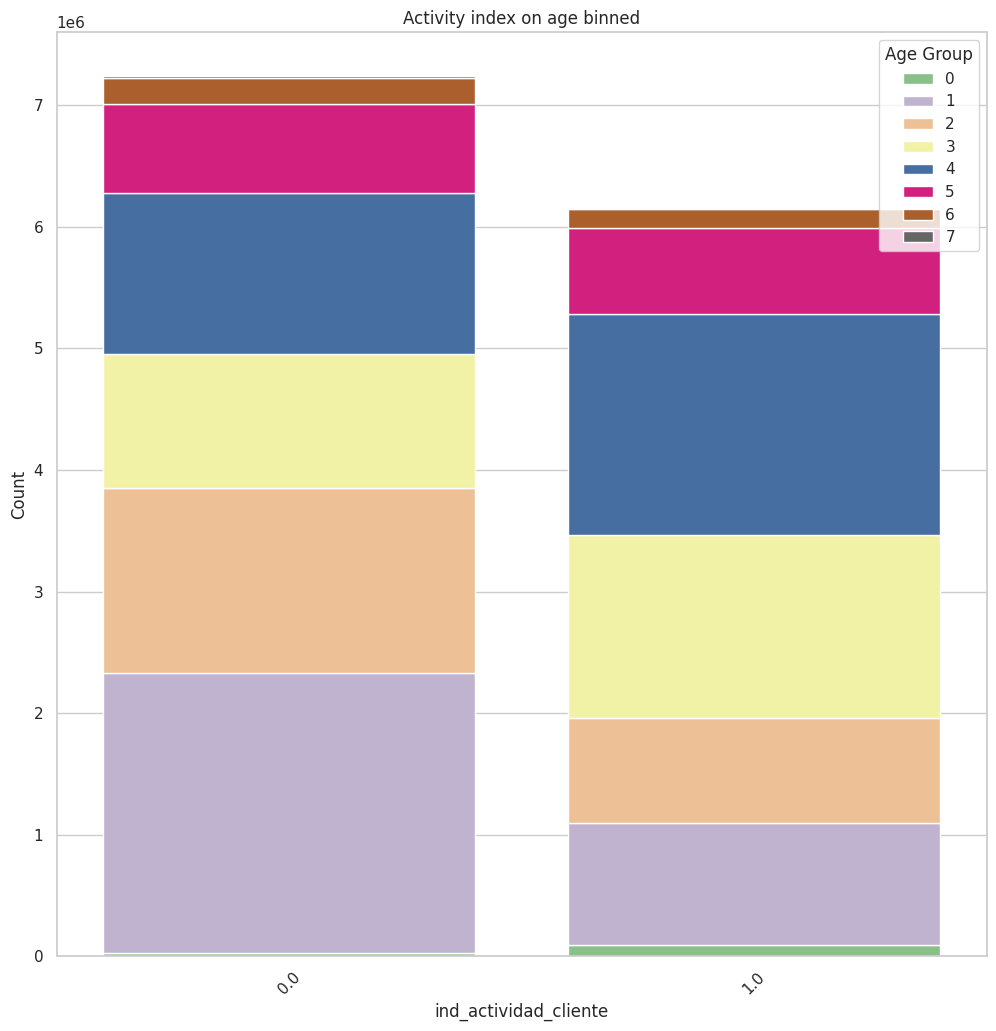

In [33]:
grouped_data = data.groupby(['ind_actividad_cliente', 'age_group']).size().unstack(fill_value=0).reset_index()


# Set seaborn style
sns.set(style="whitegrid")

# Plot stacked bar plot for age groups for each month
plt.figure(figsize=(12, 12))

# Initialize bottom values for stacking
bottom_values = None

# Iterate over each age group and plot the bars
for i, age_group in enumerate(grouped_data.columns[1:]):
    if bottom_values is None:
        ax = sns.barplot(x='ind_actividad_cliente', y=age_group, data=grouped_data, label=age_group,color=sns.color_palette("Accent")[i])
        bottom_values = grouped_data[age_group]
    else:
        ax = sns.barplot(x='ind_actividad_cliente', y=age_group, data=grouped_data, label=age_group, bottom=bottom_values,color=sns.color_palette("Accent")[i])
        bottom_values += grouped_data[age_group]

# Set plot title and labels
ax.set_title('Activity index on age binned')
ax.set_xlabel('ind_actividad_cliente')
ax.set_ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
plt.legend(title='Age Group', loc='upper right')

plt.show()

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13391339 entries, 0 to 13647307
Data columns (total 50 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   fecha_dato             object        
 1   ncodpers               int64         
 2   ind_empleado           object        
 3   pais_residencia        object        
 4   sexo                   object        
 5   fecha_alta             datetime64[ns]
 6   ind_nuevo              float64       
 7   antiguedad             object        
 8   indrel                 float64       
 9   ult_fec_cli_1t         object        
 10  indrel_1mes            object        
 11  tiprel_1mes            object        
 12  indresi                object        
 13  indext                 object        
 14  canal_entrada          object        
 15  indfall                object        
 16  tipodom                float64       
 17  cod_prov               float64       
 18  nomprov                ob

# Segmento
segmentation: 01 — VIP, 02 — Individuals 03 — college graduated

In [35]:
data.segmento.value_counts()

segmento
02 - PARTICULARES     7902276
03 - UNIVERSITARIO    4930678
01 - TOP               558385
Name: count, dtype: int64

When we analyze Age bins, we can see that both (18,25] and (25,35] age groups have maximum customers from UNIVERSITY. PARTICULAR segmentation has the maximum share from age groups other than between age 18 to 35

/tmp/ipykernel_33/1322153613.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(['segmento', 'age_group']).size().unstack(fill_value=0).reset_index()


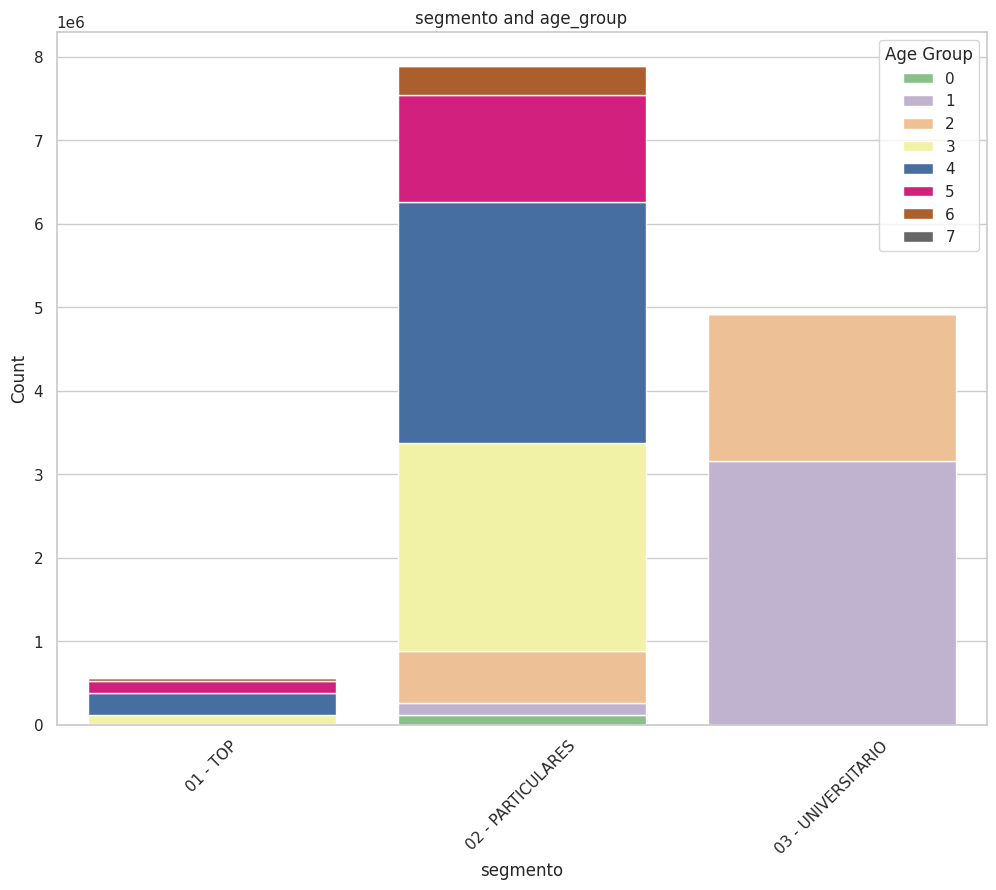

In [36]:
grouped_data = data.groupby(['segmento', 'age_group']).size().unstack(fill_value=0).reset_index()


# Set seaborn style
sns.set(style="whitegrid")

# Plot stacked bar plot for age groups for each month
plt.figure(figsize=(12,9))

# Initialize bottom values for stacking
bottom_values = None

# Iterate over each age group and plot the bars
for i, age_group in enumerate(grouped_data.columns[1:]):
    if bottom_values is None:
        ax = sns.barplot(x='segmento', y=age_group, data=grouped_data, label=age_group,color=sns.color_palette("Accent")[i])
        bottom_values = grouped_data[age_group]
    else:
        ax = sns.barplot(x='segmento', y=age_group, data=grouped_data, label=age_group, bottom=bottom_values,color=sns.color_palette("Accent")[i])
        bottom_values += grouped_data[age_group]

# Set plot title and labels
ax.set_title('segmento and age_group')
ax.set_xlabel('segmento')
ax.set_ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
plt.legend(title='Age Group', loc='upper right')

plt.show()

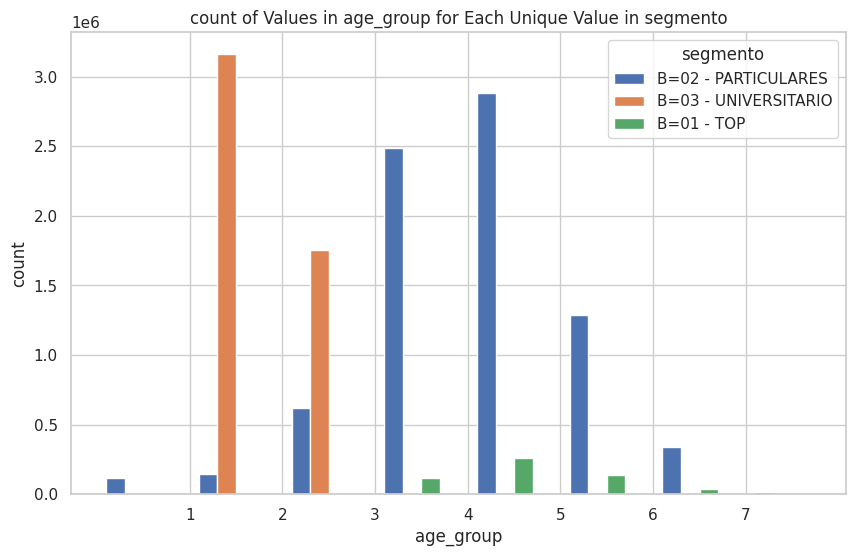

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
d = {
    'A': data['age_group'],
    'B': data['segmento']
}

# Create DataFrame
df = pd.DataFrame(d)

# Get unique values in column B
unique_values_b = df['B'].unique()

# Plotting
plt.figure(figsize=(10, 6))  # Adjust figure size if needed

for i, value_b in enumerate(unique_values_b, start=1):
    # Filter DataFrame for each unique value in B
    filtered_df = df[df['B'] == value_b]
    
    # Count frequency of each unique value of A within the group
    frequencies = filtered_df['A'].value_counts().sort_index()
    
    # Plot the frequencies as bar
    plt.bar([x + i*0.2 for x in frequencies.index], frequencies.values, width=0.2, label=f'B={value_b}')

# Adding labels and title
plt.title('count of Values in age_group for Each Unique Value in segmento')
plt.xlabel('age_group')
plt.ylabel('count')
plt.xticks(range(1, df['A'].max() + 1))  # Set x-ticks to match unique values in A
plt.legend(title='segmento')

plt.grid(True)
plt.show()

In [ ]:
bins = [0, 300, 3000, 30000, 300000, 3000000, 30000000, 300000000]

# Create a new column 'renta_group' containing the bin labels
data['renta_group'] = pd.cut(data['renta'], bins=bins, labels=False, right=False)

# renta
gross income of the household

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


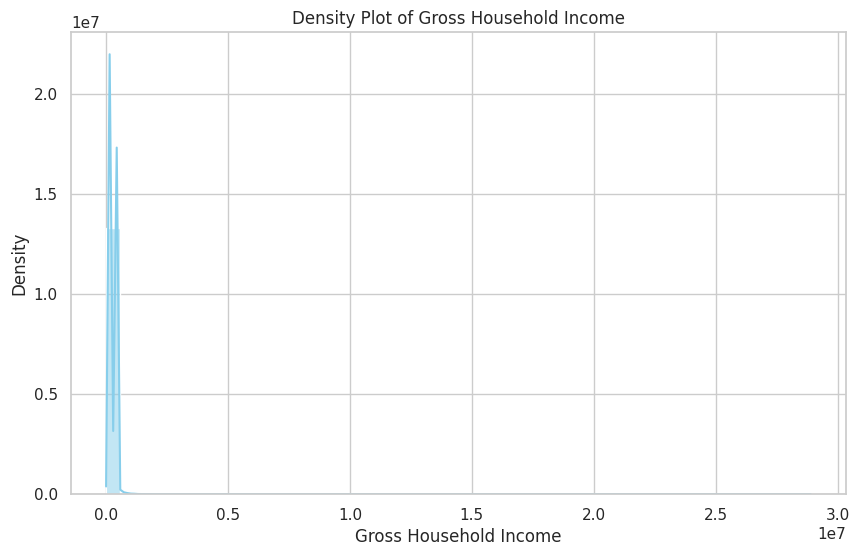

In [38]:
sns.set(style="whitegrid")

# Create the density plot
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='renta', kde=True, color='skyblue', bins=50)
plt.title('Density Plot of Gross Household Income')
plt.xlabel('Gross Household Income')
plt.ylabel('Density')
plt.show()

We can see from the above distribution plot that income is highly skewed. We have divided the income in an exponential bin of [0, 300, 3000, 30000, 300000, 3000000, 30000000, 300000000].

Customers having income between (30000, 300000] has the major Customer chunk . There were no customers whose income was either less than 300 Euro or 30,000,000 Euro

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


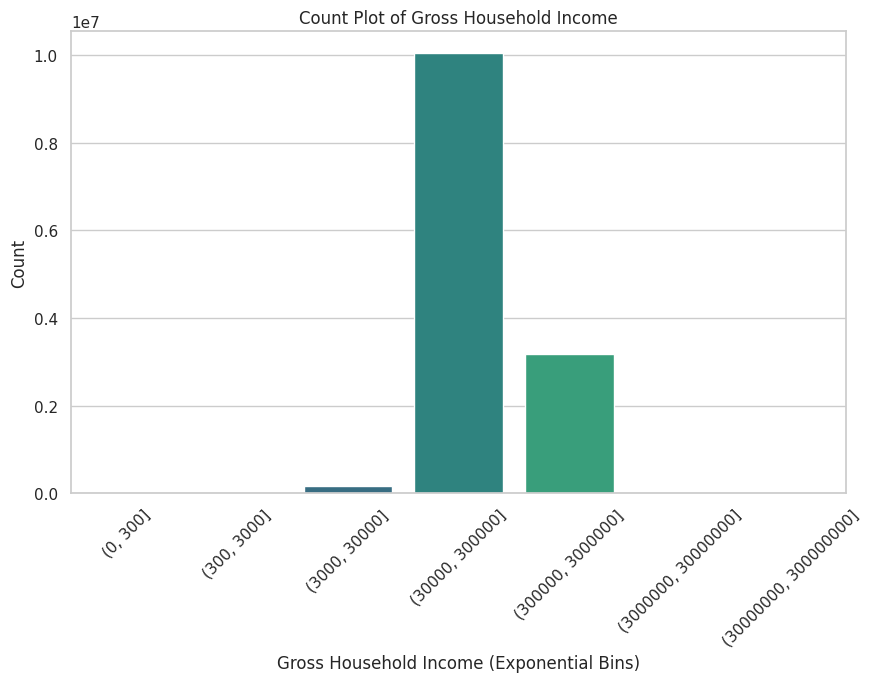

In [39]:
# Define the exponential bins
bins = [0, 300, 3000, 30000, 300000, 3000000, 30000000, 300000000]

# Create the bins for 'renta' column
data['renta_bins'] = pd.cut(data['renta'], bins=bins)

# Set seaborn style
sns.set(style="whitegrid")

# Create the count plot
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='renta_bins', palette='viridis')
plt.title('Count Plot of Gross Household Income')
plt.xlabel('Gross Household Income (Exponential Bins)')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# ind_cco_fin_ult1(Current Accounts)

1. This is the Most popular Product avail by Customers.
2. Max Current accounts are opened by Customers who fall under the age bin 18 to 25.

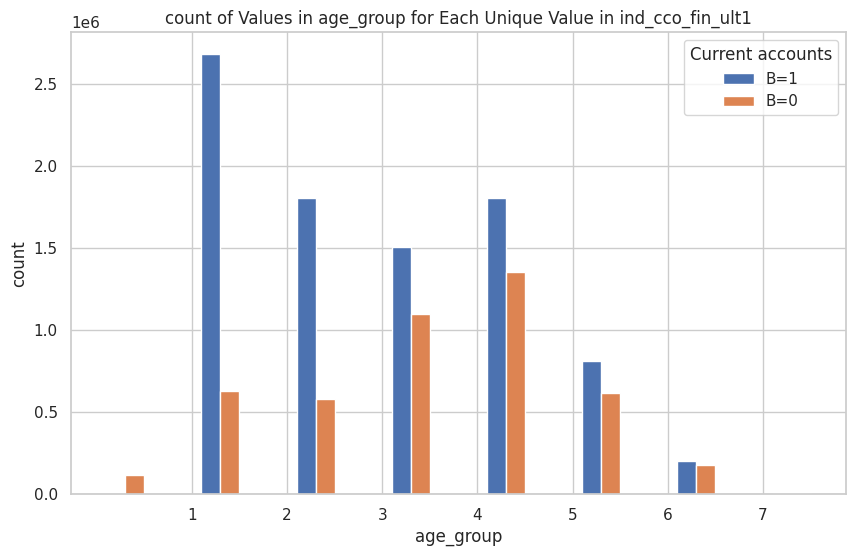

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
d = {
    'A': data['age_group'],
    'B': data['ind_cco_fin_ult1']
}

# Create DataFrame
df = pd.DataFrame(d)

# Get unique values in column B
unique_values_b = df['B'].unique()

# Plotting
plt.figure(figsize=(10, 6))  # Adjust figure size if needed

for i, value_b in enumerate(unique_values_b, start=1):
    # Filter DataFrame for each unique value in B
    filtered_df = df[df['B'] == value_b]
    
    # Count frequency of each unique value of A within the group
    frequencies = filtered_df['A'].value_counts().sort_index()
    
    # Plot the frequencies as bar
    plt.bar([x + i*0.2 for x in frequencies.index], frequencies.values, width=0.2, label=f'B={value_b}')

# Adding labels and title
plt.title('count of Values in age_group for Each Unique Value in ind_cco_fin_ult1')
plt.xlabel('age_group')
plt.ylabel('count')
plt.xticks(range(1, df['A'].max() + 1))  # Set x-ticks to match unique values in A
plt.legend(title='Current accounts')

plt.grid(True)
plt.show()

Maximum Customer opened Current accounts are in the income range from 30000 to 300000

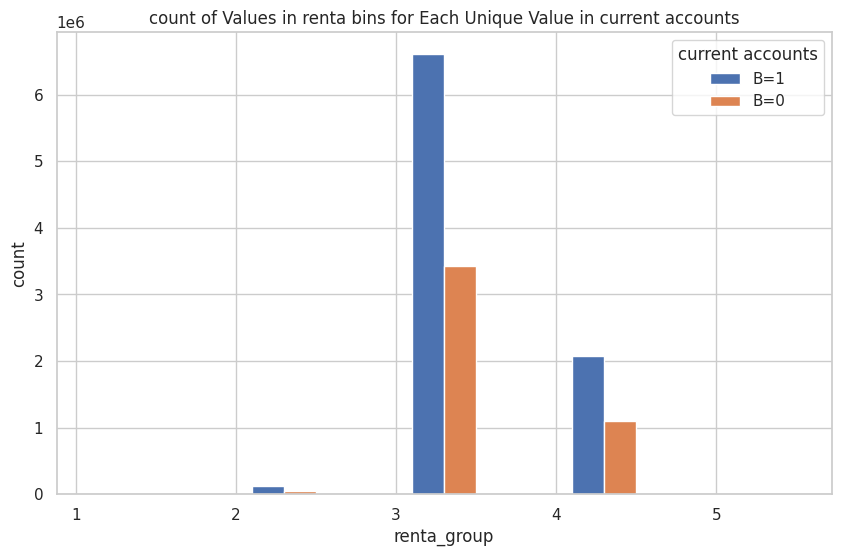

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
d = {
    'A': data['renta_group'],
    'B': data['ind_cco_fin_ult1']
}

# Create DataFrame
df = pd.DataFrame(d)

# Get unique values in column B
unique_values_b = df['B'].unique()

# Plotting
plt.figure(figsize=(10, 6))  

for i, value_b in enumerate(unique_values_b, start=1):
    # Filter DataFrame for each unique value in B
    filtered_df = df[df['B'] == value_b]
    
    # Count frequency of each unique value of A within the group
    frequencies = filtered_df['A'].value_counts().sort_index()
    
    # Plot the frequencies as bar
    plt.bar([x + i*0.2 for x in frequencies.index], frequencies.values, width=0.2, label=f'B={value_b}')

# Adding labels and title
plt.title('count of Values in renta bins for current accounts')
plt.xlabel('renta_group')
plt.ylabel('count')
plt.xticks(range(1, df['A'].max() + 1))  # Set x-ticks to match unique values in A
plt.legend(title='current accounts')

plt.grid(True)
plt.show()

# ind_cno_fin_ult1(Payroll Account)

Max Payroll accounts are opened by customers who fall under the age bin 45 to 60 and have an income range from 30000 to 300000 

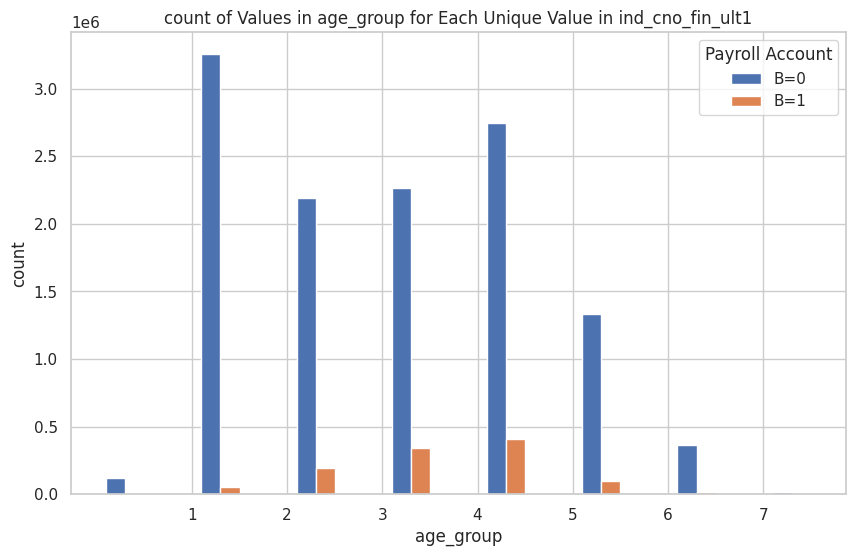

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
d = {
    'A': data['age_group'],
    'B': data['ind_cno_fin_ult1']
}

# Create DataFrame
df = pd.DataFrame(d)

# Get unique values in column B
unique_values_b = df['B'].unique()

# Plotting
plt.figure(figsize=(10, 6))  

for i, value_b in enumerate(unique_values_b, start=1):
    # Filter DataFrame for each unique value in B
    filtered_df = df[df['B'] == value_b]
    
    # Count frequency of each unique value of A within the group
    frequencies = filtered_df['A'].value_counts().sort_index()
    
    # Plot the frequencies as bar
    plt.bar([x + i*0.2 for x in frequencies.index], frequencies.values, width=0.2, label=f'B={value_b}')

# Adding labels and title
plt.title('count of Values in age_group for Each Unique Value in ind_cno_fin_ult1')
plt.xlabel('age_group')
plt.ylabel('count')
plt.xticks(range(1, df['A'].max() + 1))  # Set x-ticks to match unique values in A
plt.legend(title='Payroll Account')

plt.grid(True)
plt.show()

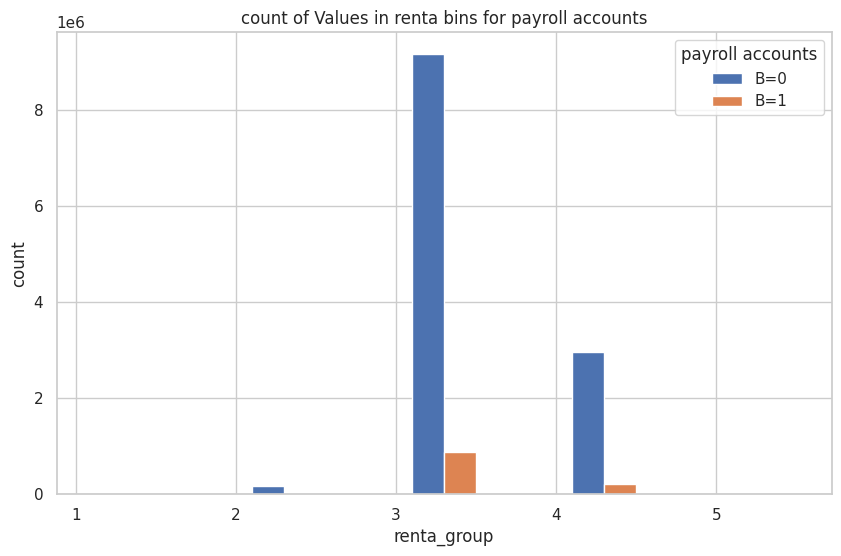

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
d = {
    'A': data['renta_group'],
    'B': data['ind_cno_fin_ult1']
}

df = pd.DataFrame(d)

# Get unique values in column B
unique_values_b = df['B'].unique()

# Plotting
plt.figure(figsize=(10, 6))  

for i, value_b in enumerate(unique_values_b, start=1):
    
    filtered_df = df[df['B'] == value_b]
    
    # Count frequency of each unique value of A within the group
    frequencies = filtered_df['A'].value_counts().sort_index()
    
    # Plot the frequencies as bar
    plt.bar([x + i*0.2 for x in frequencies.index], frequencies.values, width=0.2, label=f'B={value_b}')

# Adding labels and title
plt.title('count of Values in renta bins for payroll accounts')
plt.xlabel('renta_group')
plt.ylabel('count')
plt.xticks(range(1, df['A'].max() + 1))  
plt.legend(title='payroll accounts')

plt.grid(True)
plt.show()

# ind_ctju_fin_ult1 (Junior Account)

Max Junior accounts are opened by customers who fall under the age bin of below 18 and, have income range from 30000 to 300000 

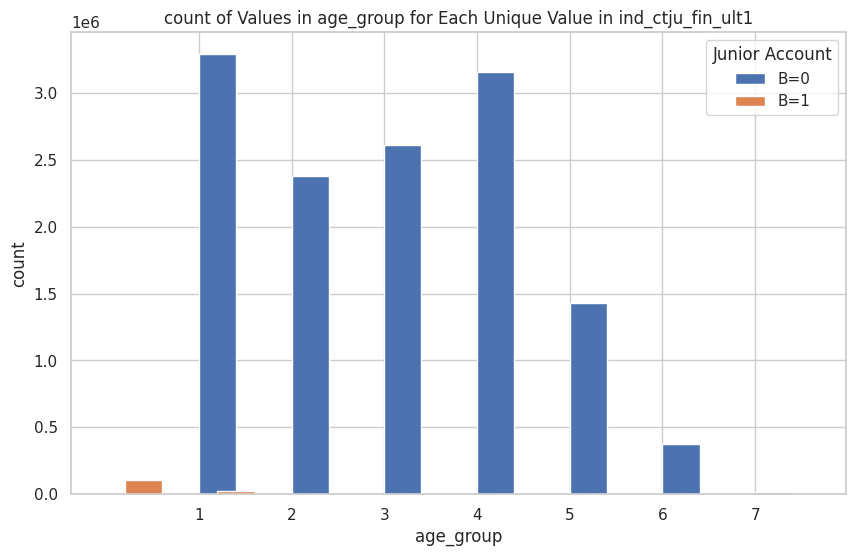

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
d = {
    'A': data['age_group'],
    'B': data['ind_ctju_fin_ult1']
}

# Create DataFrame
df = pd.DataFrame(d)

# Get unique values in column B
unique_values_b = df['B'].unique()

# Plotting
plt.figure(figsize=(10, 6))  # Adjust figure size if needed

for i, value_b in enumerate(unique_values_b, start=1):
    # Filter DataFrame for each unique value in B
    filtered_df = df[df['B'] == value_b]
    
    # Count frequency of each unique value of A within the group
    frequencies = filtered_df['A'].value_counts().sort_index()
    
    # Plot the frequencies as bar
    plt.bar([x + i*0.2 for x in frequencies.index], frequencies.values, width=0.4, label=f'B={value_b}')

# Adding labels and title
plt.title('count of Values in age_group for Each Unique Value in ind_ctju_fin_ult1')
plt.xlabel('age_group')
plt.ylabel('count')
plt.xticks(range(1, df['A'].max() + 1))  # Set x-ticks to match unique values in A
plt.legend(title='Junior Account')

plt.grid(True)
plt.show()

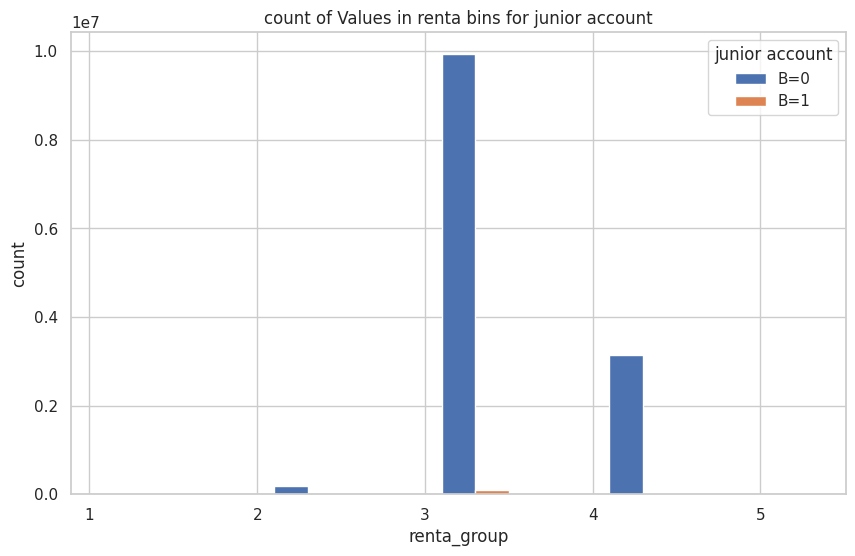

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
d = {
    'A': data['renta_group'],
    'B': data['ind_ctju_fin_ult1']
}

df = pd.DataFrame(d)

# Get unique values in column B
unique_values_b = df['B'].unique()

# Plotting
plt.figure(figsize=(10, 6))  

for i, value_b in enumerate(unique_values_b, start=1):
    
    filtered_df = df[df['B'] == value_b]
    
    # Count frequency of each unique value of A within the group
    frequencies = filtered_df['A'].value_counts().sort_index()
    
    # Plot the frequencies as bar
    plt.bar([x + i*0.2 for x in frequencies.index], frequencies.values, width=0.2, label=f'B={value_b}')

# Adding labels and title
plt.title('count of Values in renta bins for junior account')
plt.xlabel('renta_group')
plt.ylabel('count')
plt.xticks(range(1, df['A'].max() + 1))  
plt.legend(title='junior account')

plt.grid(True)
plt.show()

# ind_dela_fin_ult1 (Long-term deposits)

Max Long-term accounts are opened by customers who fall under the age bin 45 to 60, and has income range from 30000 to 300000

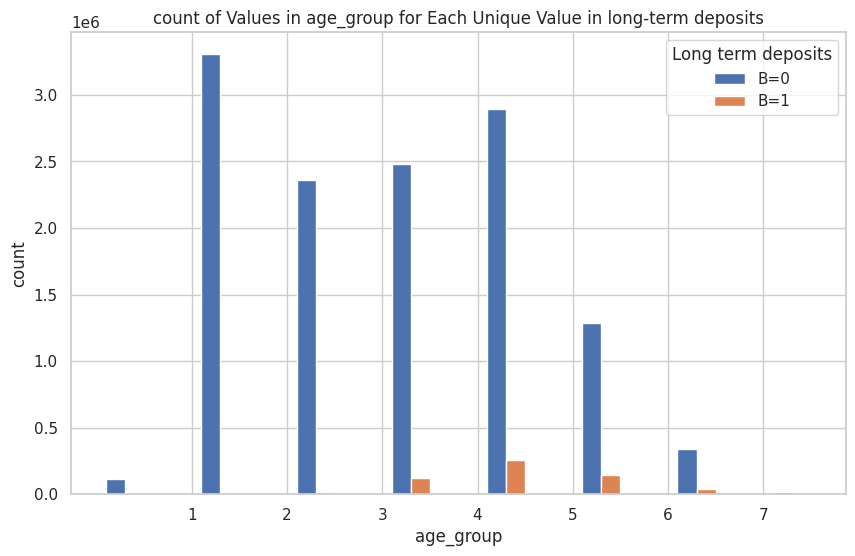

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
d = {
    'A': data['age_group'],
    'B': data['ind_dela_fin_ult1']
}

# Create DataFrame
df = pd.DataFrame(d)

# Get unique values in column B
unique_values_b = df['B'].unique()

# Plotting
plt.figure(figsize=(10, 6))  # Adjust figure size if needed

for i, value_b in enumerate(unique_values_b, start=1):
    # Filter DataFrame for each unique value in B
    filtered_df = df[df['B'] == value_b]
    
    # Count frequency of each unique value of A within the group
    frequencies = filtered_df['A'].value_counts().sort_index()
    
    # Plot the frequencies as bar
    plt.bar([x + i*0.2 for x in frequencies.index], frequencies.values, width=0.2, label=f'B={value_b}')

# Adding labels and title
plt.title('count of Values in age_group for Each Unique Value in long-term deposits')
plt.xlabel('age_group')
plt.ylabel('count')
plt.xticks(range(1, df['A'].max() + 1))  # Set x-ticks to match unique values in A
plt.legend(title='Long term deposits')

plt.grid(True)
plt.show()

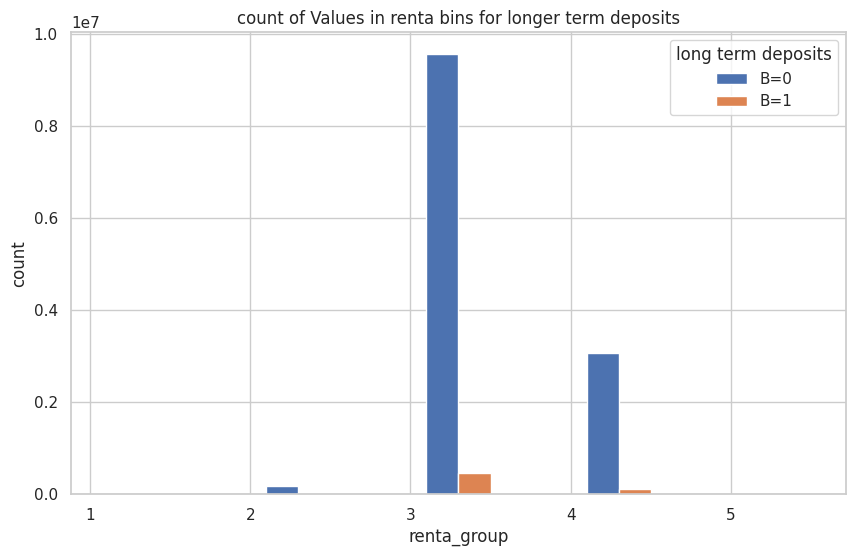

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
d = {
    'A': data['renta_group'],
    'B': data['ind_dela_fin_ult1']
}

df = pd.DataFrame(d)

# Get unique values in column B
unique_values_b = df['B'].unique()

# Plotting
plt.figure(figsize=(10, 6))  

for i, value_b in enumerate(unique_values_b, start=1):
    
    filtered_df = df[df['B'] == value_b]
    
    # Count frequency of each unique value of A within the group
    frequencies = filtered_df['A'].value_counts().sort_index()
    
    # Plot the frequencies as bar
    plt.bar([x + i*0.2 for x in frequencies.index], frequencies.values, width=0.2, label=f'B={value_b}')

# Adding labels and title
plt.title('count of Values in renta bins for longer term deposits')
plt.xlabel('renta_group')
plt.ylabel('count')
plt.xticks(range(1, df['A'].max() + 1))  
plt.legend(title='long term deposits')

plt.grid(True)
plt.show()

# ind_plan_fin_ult1 (Pensions)

Max Pensions accounts are opened by customers who fall under the age bin 45 to 60, and has income range from 30000 to 300000

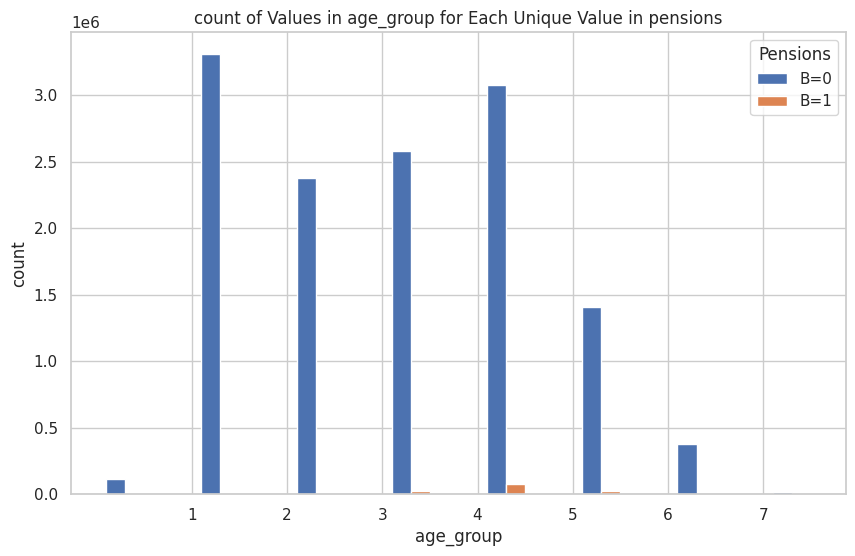

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
d = {
    'A': data['age_group'],
    'B': data['ind_plan_fin_ult1']
}

# Create DataFrame
df = pd.DataFrame(d)

# Get unique values in column B
unique_values_b = df['B'].unique()

# Plotting
plt.figure(figsize=(10, 6))  # Adjust figure size if needed

for i, value_b in enumerate(unique_values_b, start=1):
    # Filter DataFrame for each unique value in B
    filtered_df = df[df['B'] == value_b]
    
    # Count frequency of each unique value of A within the group
    frequencies = filtered_df['A'].value_counts().sort_index()
    
    # Plot the frequencies as bar
    plt.bar([x + i*0.2 for x in frequencies.index], frequencies.values, width=0.2, label=f'B={value_b}')

# Adding labels and title
plt.title('count of Values in age_group for Each Unique Value in pensions')
plt.xlabel('age_group')
plt.ylabel('count')
plt.xticks(range(1, df['A'].max() + 1))  # Set x-ticks to match unique values in A
plt.legend(title='Pensions')

plt.grid(True)
plt.show()

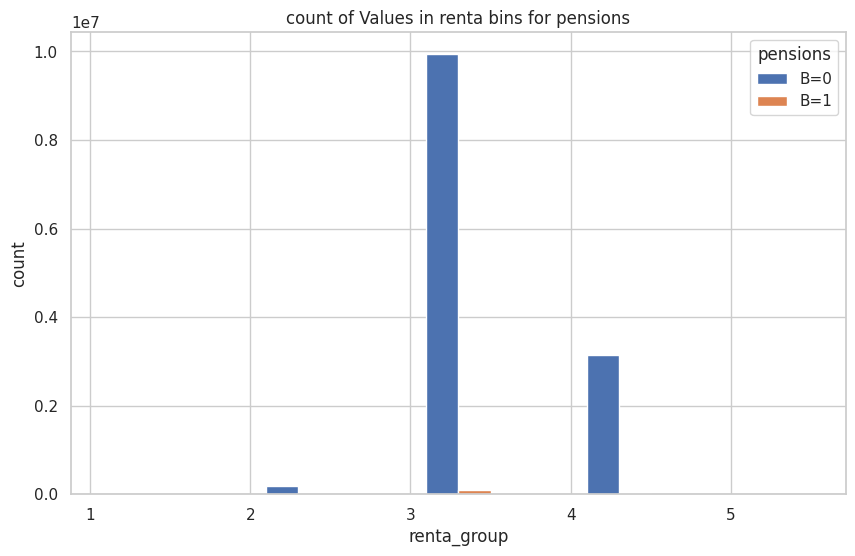

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
d = {
    'A': data['renta_group'],
    'B': data['ind_plan_fin_ult1']
}

df = pd.DataFrame(d)

# Get unique values in column B
unique_values_b = df['B'].unique()

# Plotting
plt.figure(figsize=(10, 6))  

for i, value_b in enumerate(unique_values_b, start=1):
    
    filtered_df = df[df['B'] == value_b]
    
    # Count frequency of each unique value of A within the group
    frequencies = filtered_df['A'].value_counts().sort_index()
    
    # Plot the frequencies as bar
    plt.bar([x + i*0.2 for x in frequencies.index], frequencies.values, width=0.2, label=f'B={value_b}')

# Adding labels and title
plt.title('count of Values in renta bins for pensions')
plt.xlabel('renta_group')
plt.ylabel('count')
plt.xticks(range(1, df['A'].max() + 1))  
plt.legend(title='pensions')

plt.grid(True)
plt.show()

# ind_tjcr_fin_ult1 (credit_card)

Max Credit Card accounts are opened by customers have an income range from 30000 to 300000 (3)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
d = {
    'A': data['age_group'],
    'B': data['ind_plan_fin_ult1']
}

# Create DataFrame
df = pd.DataFrame(d)

# Get unique values in column B
unique_values_b = df['B'].unique()

# Plotting
plt.figure(figsize=(10, 6))  # Adjust figure size if needed

for i, value_b in enumerate(unique_values_b, start=1):
    # Filter DataFrame for each unique value in B
    filtered_df = df[df['B'] == value_b]
    
    # Count frequency of each unique value of A within the group
    frequencies = filtered_df['A'].value_counts().sort_index()
    
    # Plot the frequencies as bar
    plt.bar([x + i*0.2 for x in frequencies.index], frequencies.values, width=0.2, label=f'B={value_b}')

# Adding labels and title
plt.title('count of Values in age_group for Each Unique Value in pensions')
plt.xlabel('age_group')
plt.ylabel('count')
plt.xticks(range(1, df['A'].max() + 1))  # Set x-ticks to match unique values in A
plt.legend(title='Pensions')

plt.grid(True)
plt.show()

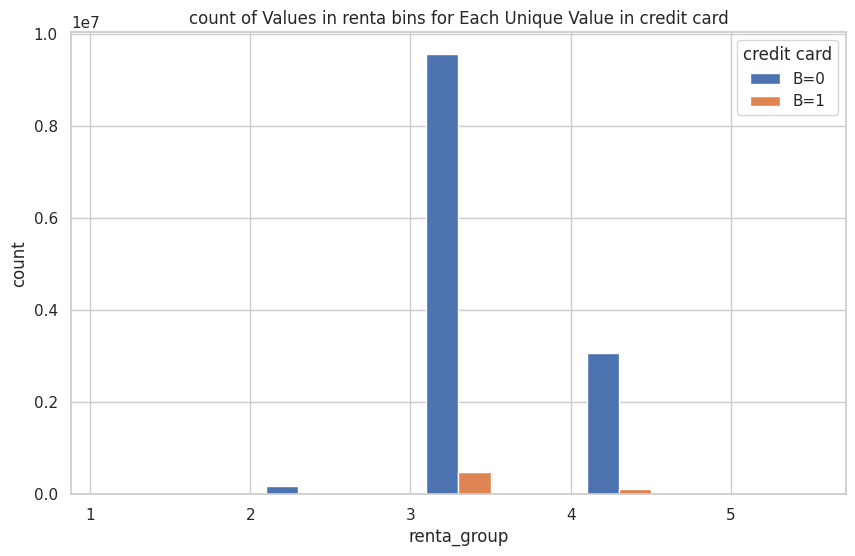

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
d = {
    'A': data['renta_group'],
    'B': data['ind_tjcr_fin_ult1']
}

# Create DataFrame
df = pd.DataFrame(d)

# Get unique values in column B
unique_values_b = df['B'].unique()

# Plotting
plt.figure(figsize=(10, 6))  # Adjust figure size if needed

for i, value_b in enumerate(unique_values_b, start=1):
    # Filter DataFrame for each unique value in B
    filtered_df = df[df['B'] == value_b]
    
    # Count frequency of each unique value of A within the group
    frequencies = filtered_df['A'].value_counts().sort_index()
    
    # Plot the frequencies as bar
    plt.bar([x + i*0.2 for x in frequencies.index], frequencies.values, width=0.2, label=f'B={value_b}')

# Adding labels and title
plt.title('count of Values in renta bins for Each Unique Value in credit card')
plt.xlabel('renta_group')
plt.ylabel('count')
plt.xticks(range(1, df['A'].max() + 1))  # Set x-ticks to match unique values in A
plt.legend(title='credit card')

plt.grid(True)
plt.show()